# DLC Live PyTorch Demo

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dlclive import DLCLive
import cv2
import numpy as np
from pathlib import Path
import time
from onnxruntime import quantization
import onnx
import onnxruntime as ort
import os

Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [4]:
projects = ["fly-kevin", "hand-track", "superbird", "ventral-gait"]

In [12]:
from pathlib import Path
from dlclibrary import download_huggingface_model

# Creates a folder and downloads the model to it
model_dir = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped_model_pytorch")
model_dir.mkdir()
download_huggingface_model("superanimal_quadruped_hrnetw32", model_dir)

Loading.... superanimal_quadruped_hrnetw32


pose_model.pth:   0%|          | 0.00/160M [00:00<?, ?B/s]

detector.pt:   0%|          | 0.00/518M [00:00<?, ?B/s]

### PyTorch to ONNX

In [95]:
# In case you do not have a .onnx model exported, use this cell to export your DLC3.0 snapshot

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
import torch
import onnxruntime as ort

device = "cuda" if torch.cuda.is_available() else "cpu"


# Dikra
root = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite")
model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
weights_path = root / "snapshot-100.pt"

# weights_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped/uadr.pth"


# Anna
# root = Path("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train")
# model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
# weights_path = root / "snapshot-263.pt"
print(model_cfg["model"])
model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights["model"])

dummy_input = torch.zeros((1, 3, 224, 224))

torch.onnx.export(
    model,
    dummy_input,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx",
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)

{'backbone': {'type': 'ResNet', 'model_name': 'resnet50_gn', 'output_stride': 16, 'freeze_bn_stats': True, 'freeze_bn_weights': False}, 'backbone_output_channels': 2048, 'heads': {'bodypart': {'type': 'HeatmapHead', 'weight_init': 'normal', 'predictor': {'type': 'HeatmapPredictor', 'apply_sigmoid': False, 'clip_scores': True, 'location_refinement': True, 'locref_std': 7.2801}, 'target_generator': {'type': 'HeatmapGaussianGenerator', 'num_heatmaps': 42, 'pos_dist_thresh': 17, 'heatmap_mode': 'KEYPOINT', 'generate_locref': True, 'locref_std': 7.2801}, 'criterion': {'heatmap': {'type': 'WeightedMSECriterion', 'weight': 1.0}, 'locref': {'type': 'WeightedHuberCriterion', 'weight': 0.05}}, 'heatmap_config': {'channels': [2048], 'kernel_size': [], 'strides': [], 'final_conv': {'out_channels': 42, 'kernel_size': 1}}, 'locref_config': {'channels': [2048], 'kernel_size': [], 'strides': [], 'final_conv': {'out_channels': 84, 'kernel_size': 1}}}}}


/tmp/ipykernel_50429/2945889587.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)


In [7]:
import ipywidgets as widgets
from IPython.display import display

model_options = dlc.create_project.modelzoo.Modeloptions
model_selection = widgets.Dropdown(
    options=model_options,
    value=model_options[0],
    description="Choose a DLC ModelZoo model!",
    disabled=False,
)
display(model_selection)

Dropdown(description='Choose a DLC ModelZoo model!', options=('full_human', 'full_cat', 'full_dog', 'primate_f…

In [13]:
project_name = "superanimal_quadruped"
your_name = "dlc24_residents"
model2use = model_selection.value
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
videotype = os.path.splitext(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
)[-1].lstrip(
    "."
)  # or MOV, or avi, whatever you uploaded!

In [ ]:
config_path, train_config_path = dlc.create_pretrained_project(
    project_name,
    your_name,
    [video_path],
    working_directory="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superanimal_quadruped_model_pytorch",
    videotype=videotype,
    model=model2use,
    analyzevideo=False,
    createlabeledvideo=False,
    copy_videos=True,
)

### Quant ONNX

In [ ]:
# FP32 to FP16 conversion
from onnxconverter_common import float16

onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx"
)
onnx_fp16_model_path = ("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite_fp16.onnx")

model_fp32 = onnx.load(onnx_fp32_model_path)
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, onnx_fp16_model_path)

In [8]:
onnx_fp32_model_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/superbird_ssdlite.onnx"
)
model_prep_path = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/resnet_quant_prep.onnx"
)

# prep for quantisation
quantization.shape_inference.quant_pre_process(
    onnx_fp32_model_path, model_prep_path, skip_symbolic_shape=False
)

In [ ]:
# ONNX model static quantization WITHOUT DATA CALIBRATION
quant_resnet = (
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/"
    + projects[3]
    + "/resnet_quant.onnx"
)
model = onnx.load(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3] + "/resnet.onnx"
)

# quant_format = ort.quantization.QuantFormat.QDQ  # Recommended format from 1.11
# activation_type = ort.quantization.QuantType.QInt8
# weight_type = ort.quantization.QuantType.QInt8


class QuantizationDataReader(quantization.CalibrationDataReader):
    def __init__(self, torch_ds, batch_size, input_name):

        self.torch_dl = torch.utils.data.DataLoader(
            torch_ds, batch_size=batch_size, shuffle=False
        )

        self.input_name = input_name
        self.datasize = len(self.torch_dl)

        self.enum_data = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return (
            pt_tensor.detach().cpu().numpy()
            if pt_tensor.requires_grad
            else pt_tensor.cpu().numpy()
        )

    def get_next(self):
        batch = next(self.enum_data, None)
        if batch is not None:
            return {self.input_name: self.to_numpy(batch[0])}
        else:
            return None

    def rewind(self):
        self.enum_data = iter(self.torch_dl)


qdr = QuntizationDataReader(
    calib_ds, batch_size=2, input_name=ort_sess.get_inputs()[0].name
)

# quantizer = quantization.QuantizeStatic(model, quant_format, activation_type, weight_type)
quant_model = quantization.quantize_static(
    model_prep_path,
    quant_resnet,
    quant_format=quant_format,
    activation_type=activation_type,
    weight_type=weight_type,
)
onnx.save(quant_model, quant_resnet)

In [101]:
# Load test frame
img = cv2.imread(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird/8aa7edce2e5f44f98f0d0ac73dedc006_553.jpg"
)

### DLC Live with ONNX exported DLC 3.0 model

In [106]:
# Dikra
onnx_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    model_type="pytorch",
    device="cuda",
    display=True,
    snapshot="snapshot-100.pt",
    # resize=0.7,
    # cropping=[0,512,0,512]
    # precision="FP16",
)

# Anna
# onnx_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# onnx_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

onnx_pose = onnx_dlc_live.init_inference(frame=img)
onnx_pose

Loading the model took 0.254169225692749 sec
PyTorch inference took 0.003065347671508789 sec
PyTorch postprocessing took 0.07213997840881348 sec


({'poses': tensor([[[[5.5056e+02, 3.4709e+02, 5.1385e-01],
            [6.9339e+02, 3.7831e+02, 5.1809e-01],
            [4.8250e+02, 1.6700e+02, 7.6433e-01],
            [5.9321e+02, 3.7561e+02, 3.0986e-01],
            [6.2806e+02, 3.4517e+02, 6.5673e-01],
            [6.4639e+02, 3.5552e+02, 6.0317e-01],
            [6.3539e+02, 3.5684e+02, 5.4960e-01],
            [4.6005e+02, 1.6846e+02, 4.6797e-01],
            [3.7940e+02, 3.8465e+02, 3.3203e-01],
            [4.6718e+02, 3.2919e+02, 2.2717e-01],
            [5.8489e+02, 3.5557e+02, 4.6419e-01],
            [6.3402e+02, 3.5767e+02, 8.2448e-01],
            [4.7162e+02, 1.7686e+02, 5.2562e-01],
            [5.4127e+02, 6.1913e+02, 3.4762e-01],
            [4.2060e+01, 1.2721e+01, 2.4560e-01],
            [4.4452e+02, 5.5158e+01, 9.1034e-01],
            [6.3097e+02, 3.7222e+02, 6.1695e-01],
            [6.2662e+02, 3.7354e+02, 1.9132e-01],
            [4.4740e+02, 5.9445e+01, 3.8444e-01],
            [3.2789e+02, 3.9531e+02, 6.18

![Screenshot from 2024-08-20 14-29-53.png](./docs/assets/Screenshot%20from%202024-08-20%2014-36-00.png)

In [107]:
onnx_pose = onnx_dlc_live.get_pose(frame=img)
onnx_pose

PyTorch inference took 0.01370382308959961 sec
PyTorch postprocessing took 0.06238055229187012 sec


({'poses': tensor([[[[5.5056e+02, 3.4709e+02, 5.1385e-01],
            [6.9339e+02, 3.7831e+02, 5.1809e-01],
            [4.8250e+02, 1.6700e+02, 7.6433e-01],
            [5.9321e+02, 3.7561e+02, 3.0986e-01],
            [6.2806e+02, 3.4517e+02, 6.5673e-01],
            [6.4639e+02, 3.5552e+02, 6.0317e-01],
            [6.3539e+02, 3.5684e+02, 5.4960e-01],
            [4.6005e+02, 1.6846e+02, 4.6797e-01],
            [3.7940e+02, 3.8465e+02, 3.3203e-01],
            [4.6718e+02, 3.2919e+02, 2.2717e-01],
            [5.8489e+02, 3.5557e+02, 4.6419e-01],
            [6.3402e+02, 3.5767e+02, 8.2448e-01],
            [4.7162e+02, 1.7686e+02, 5.2562e-01],
            [5.4127e+02, 6.1913e+02, 3.4762e-01],
            [4.2060e+01, 1.2721e+01, 2.4560e-01],
            [4.4452e+02, 5.5158e+01, 9.1034e-01],
            [6.3097e+02, 3.7222e+02, 6.1695e-01],
            [6.2662e+02, 3.7354e+02, 1.9132e-01],
            [4.4740e+02, 5.9445e+01, 3.8444e-01],
            [3.2789e+02, 3.9531e+02, 6.18

In [104]:
onnx_dlc_live.display.destroy()

### DLC Live with snaptshot of DLC 3.0 model (.pt)

In [69]:
# Dikra
pytorch_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    snapshot="snapshot-263.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

# Anna
# pytorch_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# pytorch_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

pytorch_pose = pytorch_dlc_live.init_inference(frame=img)
pytorch_pose

/home/dikra/MyHub/Code/DLC24_Hub/DLC_AI2024/DeepLabCut-live/dlclive/dlclive.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path, map_locati

Loading the model took 0.4676992893218994 sec
PyTorch inference took 0.034587860107421875 sec
PyTorch postprocessing took 0.0018115043640136719 sec


({'poses': tensor([[[[154.0203, 162.2280,   0.9152],
            [146.8848, 158.9930,   0.9459],
            [150.3487, 149.1102,   0.9093],
            [196.7133, 137.2184,   0.8843],
            [204.8920, 172.0188,   0.6791],
            [342.8778,  81.4373,   0.6930],
            [325.4101, 151.0759,   0.7803],
            [240.2807, 110.5330,   0.6488],
            [261.0057, 128.8403,   0.6076],
            [254.8730, 154.8122,   0.8238],
            [385.2763, 112.8773,   0.8098]]]])},
 0.034587860107421875)

In [70]:
pytorch_dlc_live.display.destroy()

![PyTorch model inference](./docs/assets/Screenshot%20from%202024-08-20%2014-29-53.png)

### Which is faster?

Independent frame analysis

In [10]:
import glob
import os

root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird"
test_images = glob.glob(os.path.normpath(root + "/*.jpg"))


def mean_time_inference(dlc_live, images):
    poses, times = [], []
    for i, img_p in enumerate(images):
        print("Frame # ", i)
        img = cv2.imread(img_p)

        if i == 0:
            pose, t = dlc_live.init_inference(img)
        else:
            pose, t = dlc_live.get_pose(img)
        poses.append(pose)
        times.append(t)

    return times, poses

In [10]:
projects

['fly-kevin', 'hand-track', 'superbird', 'ventral-gait']

In [18]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    device="cuda",
    model_type="onnx",
    snapshot="snapshot-100.pt",
    display=True,
)

times, poses = mean_time_inference(dlc_live, test_images)

Frame #  0
Loading the model took 0.0992898941040039 sec
ONNX inference took 1.002748966217041 sec
ONNX postprocessing took 0.0037970542907714844 sec
Frame #  1
ONNX inference took 1.185469627380371 sec
ONNX postprocessing took 0.0041692256927490234 sec
Frame #  2
ONNX inference took 1.1702406406402588 sec
ONNX postprocessing took 0.00862884521484375 sec
Frame #  3
ONNX inference took 1.6595604419708252 sec
ONNX postprocessing took 0.004779815673828125 sec
Frame #  4
ONNX inference took 1.5690531730651855 sec
ONNX postprocessing took 0.003983974456787109 sec
Frame #  5
ONNX inference took 0.3981649875640869 sec
ONNX postprocessing took 0.0015933513641357422 sec
Frame #  6
ONNX inference took 0.5557830333709717 sec
ONNX postprocessing took 0.002658367156982422 sec
Frame #  7
ONNX inference took 1.6932966709136963 sec
ONNX postprocessing took 0.006421804428100586 sec
Frame #  8
ONNX inference took 1.2120893001556396 sec
ONNX postprocessing took 0.0041429996490478516 sec


In [19]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

In [78]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    device="tensorrt",
    model_type="onnx",
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 4.69077205657959 sec
ONNX inference took 49.87957811355591 sec
ONNX postprocessing took 0.0015039443969726562 sec
[54.57309126853943]
Inference of PyTorch model took on average 54.57309126853943 seconds for 1 images


In [81]:
start = time.time()
dlc_live.get_pose(img)
end = time.time()

ONNX inference took 0.02220296859741211 sec
ONNX postprocessing took 0.0027968883514404297 sec


# Video analysis

Currently the benchmark_pytorch.py script serves to provide a function for analyzing a preexisting video to test PyTorch for running video inference in DLC-Live. Code for running video inference on a live video feed is WIP.

For true benchmarking purposes, we aim to add feature for recording the time it takes to analyze each frame / how many frames can be analyzed per second. Discuss what measure to use and consult the DLC Live paper

In [5]:
%load_ext autoreload
%autoreload 2

# Import the analyze_video function from the file where it's defined
from dlclive.benchmark_pytorch import analyze_video

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [9]:
# test download of benchmarking dataset
# OBS link it not working, waiting for updated link to benchmarking dataset

dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    device="cuda",
    snapshot="snapshot-100.pt",
    model_type="onnx",
    display=True,
    precision="FP16",
)
# short video
# video_path = '/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/1_20cms_0degUP_first_1s.avi'
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/pigeon_superanimal_topviewmouse_hrnetw32.mp4"

poses, times = analyze_video(
    video_path=video_path,
    model_type="pytorch",
    snapshot = "snapshot-100.pt",
    device="cuda",
    precision="FP16",
    resize=0.25,
    # cropping= [50, 250, 100, 450], # manually set the cropping to specific pixels
    # dynamic=(True,0.5,10,),
    model_path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite",
    display=True,
    save_poses=False,
    save_dir="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird_ssdlite/out",
    draw_keypoint_names=False,
)

Loading the model took 0.2802889347076416 sec
PyTorch inference took 0.0036814212799072266 sec
PyTorch postprocessing took 0.013600349426269531 sec
Frame 0 processing time: 0.4215 seconds
PyTorch inference took 0.01842188835144043 sec
PyTorch postprocessing took 0.01550912857055664 sec
Frame 1 processing time: 0.0540 seconds
PyTorch inference took 0.00528407096862793 sec
PyTorch postprocessing took 0.012547969818115234 sec
Frame 2 processing time: 0.0261 seconds
PyTorch inference took 0.011702775955200195 sec
PyTorch postprocessing took 0.015716552734375 sec
Frame 3 processing time: 0.0482 seconds
PyTorch inference took 0.02461075782775879 sec
PyTorch postprocessing took 0.03164196014404297 sec
Frame 4 processing time: 0.0836 seconds
PyTorch inference took 0.007582902908325195 sec
PyTorch postprocessing took 0.028603553771972656 sec
Frame 5 processing time: 0.0447 seconds
PyTorch inference took 0.010408878326416016 sec
PyTorch postprocessing took 0.018442153930664062 sec
Frame 6 proces

KeyboardInterrupt: 

In [41]:
times = [p["pose"][1] for p in poses]

Mean ± std inference time per frame

In [17]:
print(
    "Mean inference time excluding 1st inference ",
    np.round(np.mean(times[1:]) * 1000, 2),
    "ms ±",
    np.round(np.std(times[1:]) * 1000, 2),
)
print(
    "Mean inference time including 1st inference ",
    np.round(np.mean(times) * 1000, 2),
    "ms ±",
    np.round(np.std(times) * 1000, 2),
)

Mean inference time excluding 1st inference  61.88 ms ± 1.43
Mean inference time including 1st inference  66.34 ms ± 108.21


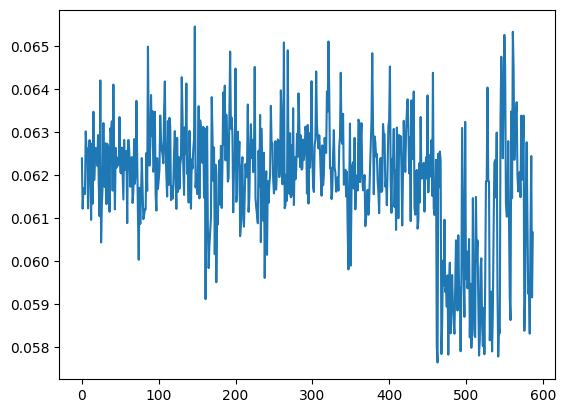

In [18]:
import matplotlib.pyplot as plt

plt.plot(times[1:])

### Compute fps from inference times

In [19]:
import numpy as np


def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps


average_fps, std_dev_fps = calculate_fps_stats(times)

print("Average FPS:", average_fps)
print("Standard Deviation of FPS:", std_dev_fps)

Average FPS: 16.142290172732356
Standard Deviation of FPS: 0.7541644897674918


### Get model size

In [19]:
import torch


def get_model_size(model_path):
    """
    Calculates the size of an ONNX model in bytes.

    Args:
        model_path (str): The path to the ONNX model file.

    Returns:
        int: The size of the model in bytes.
    """
    if ".onnx" in model_path:
        model = onnx.load(model_path)
        size_bytes = len(model.SerializeToString())
    elif ".pt" in model_path:
        model = torch.load(model_path)
        params = list(model.parameters())
        size_bytes = sum([p.numel() * p.element_size() for p in params])

    # Convert to KB, MB, GB, etc.
    if size_bytes < 1024:
        size_str = f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        size_str = f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024 * 1024 * 1024:
        size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size_str


get_model_size(
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/resnet_fp16.onnx"
)

'46.16 MB'

### Get video characteristics

In [53]:
import cv2


def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) * 0.25
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) * 0.25

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)


# Example usage:
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird/pigeon_superanimal_topviewmouse_hrnetw32.mp4"
fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 29.97
Number of frames: 1077.0
Video length (seconds): 35.93593593593594
Frame size: (480.0, 270.0)
